In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
data = pd.read_csv('breastcancer.csv', header=None)
X = data.iloc[:,:-1].values
y = (data.iloc[:,-1].values).reshape(-1,1)

In [5]:
class BinaryLogisticRegression:
    def __init__(self):
        self.w = None
        self.log = list()
        
    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def pred(self, X_test):
        y_pred = X_test @ self.w
        return self.sigmoid(y_pred) - 10**(-15)
    
    def fit(self,X_train, y_train, alpha=0.01, epochs=100):
        self.w = np.ones((X_train.shape[1],1))
        self.log = list()
        for _ in range(epochs):
            for i in range(X_train.shape[0]):
                y_pred = self.sigmoid(self.w.T @ X_train[i])
                e = y_train[i] - y_pred
                self.w += (alpha*(e@(X_train[i].reshape(1,-1)))).reshape(-1,1)
                self.log.append(self.get_bce_loss(X_train,y_train).item())
                
    def get_bce_loss(self, X, y):
        y_pred = self.pred(X)
        bce = -(((y*np.log(y_pred) + (1 - y)*np.log(1 - y_pred)).sum(axis=0))/(X.shape[0]))
        return bce
    
    def get_log(self):
        return self.log

In [6]:
kf = KFold(n_splits=10,shuffle=True)
accuracies = list()
logs = list()
normalizer = StandardScaler()
model = BinaryLogisticRegression()
cm_total = np.zeros((2, 2))

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X[train_index], X[test_index], y[train_index], y[test_index])
    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.transform(X_test)
    
    X_train = np.c_[np.ones((X_train.shape[0],1)), X_train]
    X_test = np.c_[np.ones((X_test.shape[0],1)), X_test]
    
    model.fit(X_train, y_train, epochs=10)
    y_pred = model.pred(X_test)
    y_pred_filter = np.where(y_pred < 0.5, 0, 1)
    acc = accuracy_score(y_test, y_pred_filter)
    cm = confusion_matrix(y_test, y_pred_filter, normalize='true')
    cm_total += cm
    accuracies.append([acc, cm[0][0], cm[1][1]])
    logs.append(model.get_log())
    
print("Acurácia média: {:.2f}".format(np.mean(accuracies)))
print("Desvio padrão da acurácia: {:.2f}".format(np.std(accuracies)))

Acurácia média: 0.97
Desvio padrão da acurácia: 0.03


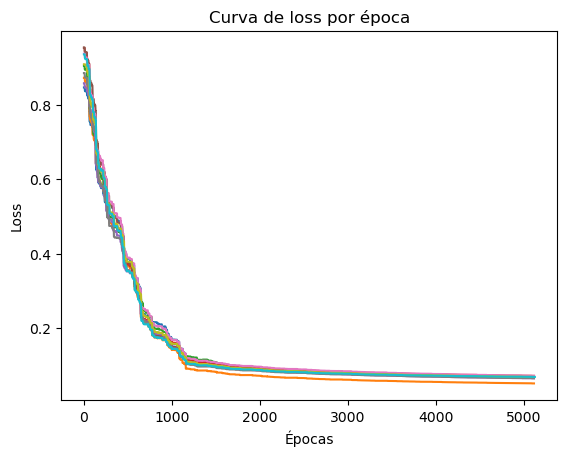

In [7]:
plt.title('Curva de loss por época')
plt.xlabel('Épocas')
plt.ylabel('Loss')
for i in range(10):
    rng = range(len(logs[i]))
    plt.plot(rng, logs[i])
plt.show()

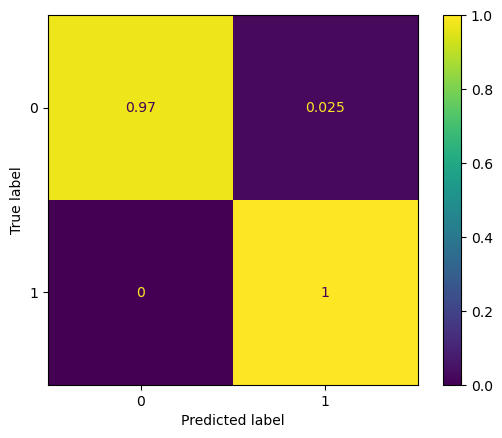

In [8]:
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [9]:
class GaussianDiscriminantAnalysis:
    def __init__(self):
        self.means = None
        self.probabilities = None
        self.covariancies = None
        self.classes = None
        
    def fit(self, X_train, y_train):
        self.means = list()
        self.probabilities = list()
        self.covariancies = list()
        self.classes = np.unique(y_train, axis=0)
        
        for clss in self.classes:
            indexes = np.argwhere((y_train == clss).all(1))
            X_train_class = X_train[indexes]
            y_train_class = y_train[indexes]
            self.probabilities.append(y_train_class.shape[0]/y_train.shape[0])
            self.means.append(np.mean(X_train_class, axis=0))
            self.covariancies.append(np.cov(X_train.T))
            
        self.probabilities = np.array(self.probabilities)
        self.means = np.array(self.means)
        self.covariancies = np.array(self.covariancies)
        
    def pred(self, X_test):
        predicted = np.zeros((self.classes.shape[0], X_test.shape[0]))
        for i in range(len(self.classes)):
            predicted[i] = (np.log(self.probabilities[i]) - (0.5)*np.log(np.linalg.norm(self.covariancies[i])) - (0.5)*(X_test - self.means[i])@np.linalg.solve(self.covariancies[i], (X_test - self.means[i]).T)).diagonal()
        return np.argmax(predicted, axis=0)

In [10]:
kf = KFold(n_splits=10, shuffle=True)
accuracies = list()
model = GaussianDiscriminantAnalysis()
for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X[train_index], X[test_index], y[train_index], y[test_index])
    model.fit(X_train, y_train)
    y_pred = model.pred(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    accuracies.append([acc, cm[0][0], cm[1][1]])
    
print("Acurácia média: {:.2f}".format(np.mean(accuracies)))
print("Desvio padrão da acurácia: {:.2f}".format(np.std(accuracies)))

Acurácia média: 0.91
Desvio padrão da acurácia: 0.11


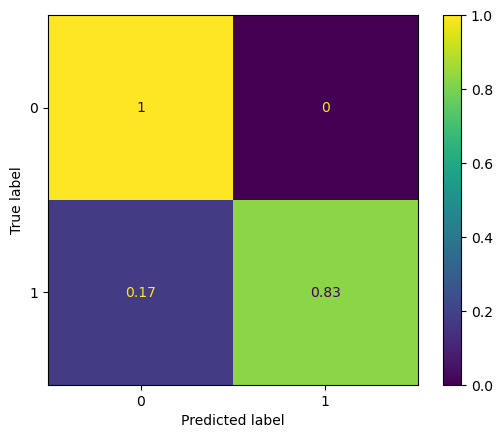

In [11]:
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [12]:
class GaussianNaiveBayes:
    def __init__(self):
        self.means = None
        self.probabilities = None
        self.variancies = None
        self.classes = None
        
    def fit(self, X_train, y_train):
        self.means = list()
        self.probabilities = list()
        self.variancies = list()
        self.classes = np.unique(y_train, axis=0)
        
        for clss in self.classes:
            indexes = np.argwhere((y_train == clss).all(1))
            X_train_class = X_train[indexes]
            y_train_class = y_train[indexes]
            self.probabilities.append(y_train_class.shape[0]/y_train.shape[0])
            self.means.append(np.mean(X_train_class, axis=0))
            self.variancies.append(np.var(X_train_class, axis=0))
            
        self.means = np.array(self.means)
        self.probabilities = np.array(self.probabilities)
        self.variancies = np.array(self.variancies)
        
    def pred(self, X_test):
        predicted = np.zeros((self.classes.shape[0], X_test.shape[0])) 
        for i in range(len(self.classes)):
            predicted[i] = np.log(self.probabilities[i]) - (0.5)*(np.log(2*np.pi*self.variancies[i])).sum(axis=1) - (0.5)*(np.power((X_test - self.means[i]), 2)/self.variancies[i]).sum(axis=1)
        return np.argmax(predicted, axis=0)                                                                  

In [13]:
kf = KFold(n_splits=10, shuffle=True)
accuracies = list()
model = GaussianNaiveBayes()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X[train_index], X[test_index], y[train_index], y[test_index])
    model.fit(X_train, y_train)
    y_pred = model.pred(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    accuracies.append([acc, cm[0][0], cm[1][1]])
    
print("Acurácia média: {:.2f}".format(np.mean(accuracies)))
print("Desvio padrão da acurácia: {:.2f}".format(np.std(accuracies)))

Acurácia média: 0.93
Desvio padrão da acurácia: 0.05


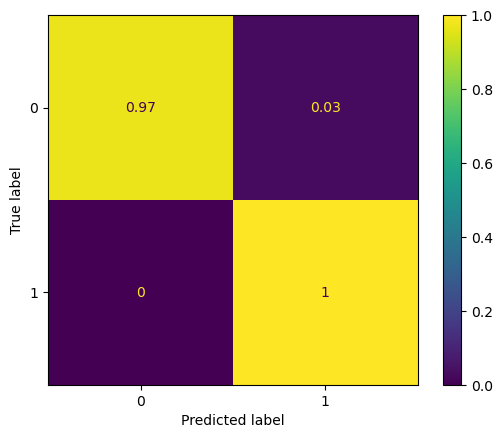

In [14]:
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [15]:
data = pd.read_csv('vehicle.csv', header=None)
X = data.iloc[:,:-1].values
y = (data.iloc[:,-1].values).reshape(-1,1)

In [16]:
class SoftMaxRegression:
    def __init__(self):
        self.w = None
        self.log = list()
    
    def pred(self, X_test):
        z = X_test @ self.w.T
        return (np.exp(z)/np.exp(z).sum())
    
    def get_mcce_loss(self, X_test, y_test):
        y_pred = self.pred(X_test)
        return -np.mean(np.sum(y_test * np.log(y_pred + 1e-15), axis=1))
    
    def fit(self, X_train, y_train, alpha=0.01, epochs=100):
        classes = np.unique(y_train, axis=0)
        self.w = np.zeros((len(classes), X_train.shape[1]))
        
        for _ in range(epochs):
            for j in range(X_train.shape[0]):
                y_pred = self.pred(np.array([X_train[j]]))
                error = y_train[j] - y_pred[0]
                self.w += (alpha*(error.reshape(-1,1)@(X_train[j]).reshape(1,-1)))
            self.log.append(self.get_mcce_loss(X_train, y_train).item())
                
    def get_log(self):
        return self.log

In [17]:
kf = KFold(n_splits=10, shuffle=True)
accuracies = list()
class_accuracies = list()
logs = list()
normalizer = MinMaxScaler()
model = SoftMaxRegression()
cm_total = np.zeros((len(np.unique(y)), len(np.unique(y))))
ohe = OneHotEncoder()
y_cod = ohe.fit_transform(y).toarray()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y_cod[train_index], y_cod[test_index]
    X_train = normalizer.fit_transform(X_train)
    X_test = normalizer.transform(X_test)
    
    X_train = np.c_[np.ones((X_train.shape[0], 1)), X_train]
    X_test = np.c_[np.ones((X_test.shape[0], 1)), X_test]
    
    model.fit(X_train, y_train, epochs=200)
    y_pred = model.pred(X_test)
    y_pred_where = np.argmax(y_pred, axis=1).reshape(-1, 1)
    y_pred_where = ohe.transform(y_pred_where).toarray()
    acc = accuracy_score(y_test.argmax(axis=1), y_pred_where.argmax(axis=1))
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred_where.argmax(axis=1), normalize='true')
    
    cm_total += cm
    accuracies.append(acc)
    class_accuracies.append(cm.diagonal())
    logs.append(model.get_log())
    
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

class_accuracies = np.array(class_accuracies)
mean_class_accuracies = np.mean(class_accuracies, axis=0)
std_class_accuracies = np.std(class_accuracies, axis=0)

print("Acurácia média: {:.2f}".format(mean_accuracy))
print("Desvio padrão da acurácia: {:.2f}".format(std_accuracy))
print("Acurácia média por classe: {}".format(mean_class_accuracies))
print("Desvio padrão da acurácia por classe: {}".format(std_class_accuracies))

Acurácia média: 0.75
Desvio padrão da acurácia: 0.05
Acurácia média por classe: [0.89859941 0.51630995 0.6171195  0.96643129]
Desvio padrão da acurácia por classe: [0.07480497 0.12204975 0.09716306 0.02962216]


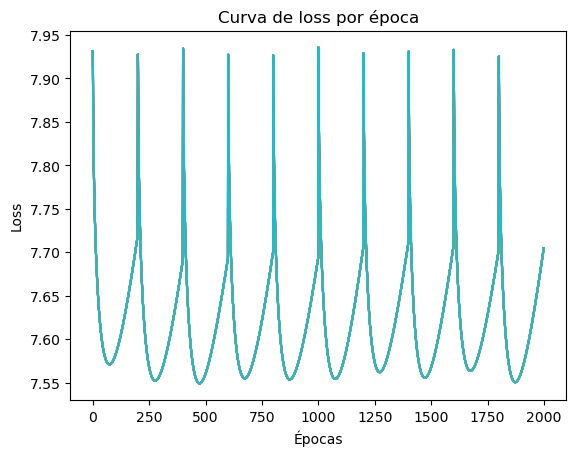

In [18]:
plt.title('Curva de loss por época')
plt.xlabel('Épocas')
plt.ylabel('Loss')
for i in range(0, 10):
    rng = range(len(logs[i]))
    plt.plot(rng, logs[i])
plt.show()

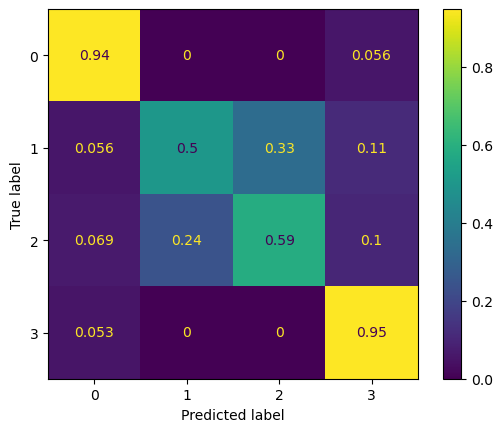

In [19]:
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [20]:
kf = KFold(n_splits=10, shuffle=True)
accuracies = list()
class_accuracies = list()
model = GaussianDiscriminantAnalysis()
for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X[train_index], X[test_index], y[train_index], y[test_index])
    model.fit(X_train, y_train)
    y_pred = model.pred(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    class_accuracies.append(cm.diagonal())
    accuracies.append(acc)
    
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

class_accuracies = np.array(class_accuracies)
mean_class_accuracies = np.mean(class_accuracies, axis=0)
std_class_accuracies = np.std(class_accuracies, axis=0)

print("Acurácia média: {:.2f}".format(mean_accuracy))
print("Desvio padrão da acurácia: {:.2f}".format(std_accuracy))
print("Acurácia média por classe: {}".format(mean_class_accuracies))
print("Desvio padrão da acurácia por classe: {}".format(std_class_accuracies))

Acurácia média: 0.76
Desvio padrão da acurácia: 0.05
Acurácia média por classe: [0.95175214 0.60497682 0.58964678 0.93257781]
Desvio padrão da acurácia por classe: [0.0456094  0.07909096 0.16031217 0.03934733]


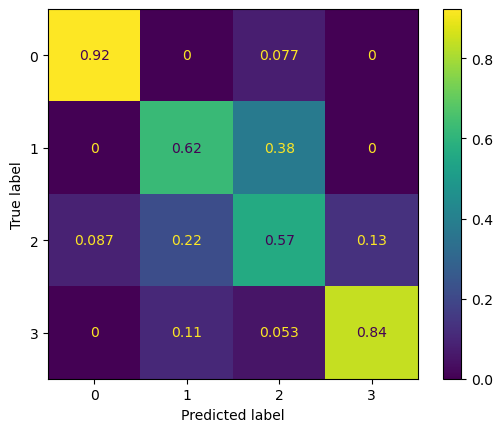

In [21]:
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()

In [22]:
kf = KFold(n_splits=10, shuffle=True)
accuracies = list()
class_accuracies = list()
model = GaussianNaiveBayes()
for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X[train_index], X[test_index], y[train_index], y[test_index])
    model.fit(X_train, y_train)
    y_pred = model.pred(X_test)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    class_accuracies.append(cm.diagonal())
    accuracies.append(acc)
    
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

class_accuracies = np.array(class_accuracies)
mean_class_accuracies = np.mean(class_accuracies, axis=0)
std_class_accuracies = np.std(class_accuracies, axis=0)

print("Acurácia média: {:.2f}".format(mean_accuracy))
print("Desvio padrão da acurácia: {:.2f}".format(std_accuracy))
print("Acurácia média por classe: {}".format(mean_class_accuracies))
print("Desvio padrão da acurácia por classe: {}".format(std_class_accuracies))

Acurácia média: 0.47
Desvio padrão da acurácia: 0.04
Acurácia média por classe: [0.17450509 0.42843167 0.43064995 0.87342491]
Desvio padrão da acurácia por classe: [0.07293001 0.10355474 0.08505934 0.07882671]


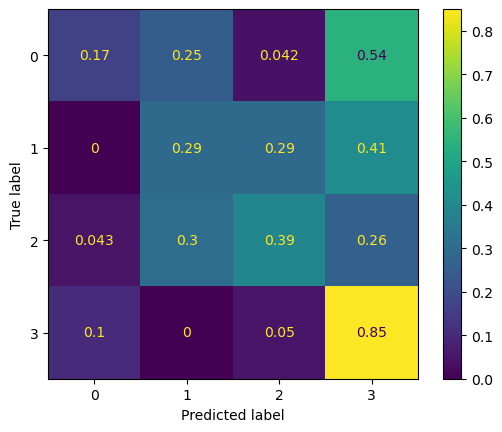

In [23]:
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
plt.show()